<a href="https://colab.research.google.com/github/MLP-deepdreamteam/Practice_captioning/blob/branch_%EB%B0%B1%EC%9A%B4%EC%B2%A0/coco_custom30k_23041402.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model

In [3]:
from google.colab import auth
auth.authenticate_user()

### 드라이브 마운트 & os확인

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
#  gs://coco_custom30k/custom30k.zip

In [6]:
from zipfile import ZipFile

In [7]:
# !wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip # 전체롤드

In [8]:
! gsutil cp gs://coco_custom30k/custom30k.zip /content/coco_custom30k

Copying gs://coco_custom30k/custom30k.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][  4.6 GiB/  4.6 GiB]  121.8 MiB/s                                   
Operation completed over 1 objects/4.6 GiB.                                      


In [9]:
with ZipFile("/content/coco_custom30k") as zfile:
  zfile.extractall(".")

In [2]:
import os
sample_path ="/content/content/custom_train_coco_30k"
sample_train = os.listdir(sample_path)

# print(sample_train[:3])

In [3]:
print(len(sample_train), sample_train[:3])

30000 ['000000041135.jpg', '000000540452.jpg', '000000166533.jpg']


In [4]:
# with GFile("gs://coco_custom30k/custom30k.zipl", "rb") as f:
#     dataset = pickle.load(f)

# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json

In [5]:
import pandas as pd
import json
# i = 0
# with open(f'/content/drive/MyDrive/coco_ann2017/annotations/captions_train2017.json', 'r') as f: # 마운트 확인
#윤성(230412)
with open(f'/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/captions_train2017.json', 'r') as f: # 마운트 확인
# with open(f'/content/drive/Shareddrives/coco_dataset/annotations/captions_train2017.json', 'r') as f: # 마운트 확인


    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption'],sample['image_id']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption','image_id'])
captions['image'] = captions['image'].apply(
    lambda x: f'/content/drive/MyDrive/coco_dataset//train2017/{x}'
)
captions = captions.reset_index(drop=True)
print(captions.head(3))



                                               image  \
0  /content/drive/MyDrive/coco_dataset//train2017...   
1  /content/drive/MyDrive/coco_dataset//train2017...   
2  /content/drive/MyDrive/coco_dataset//train2017...   

                                             caption  image_id  
0  A bicycle replica with a clock as the front wh...    203564  
1  A room with blue walls and a white sink and door.    322141  
2  A car that seems to be parked illegally behind...     16977  


In [6]:
df_captions_in_COCO = captions.groupby(["image", "image_id"])['caption'].apply(list).reset_index()


df_captions_in_COCO.shape


# # display(df_captions_in_COCO)

## sample 30k 생성용 
# # caption 길이가 5 이상이면 drop
# df_captions_in_COCO = df_captions_in_COCO[df_captions_in_COCO['caption'].apply(len) < 6]

# sample_30k  = df_captions_in_COCO.sample(30_000)




(118287, 3)

In [7]:
# 캡션 내역 확인
df_captions_in_COCO.head()
print(df_captions_in_COCO.shape)

print(
df_captions_in_COCO.iloc[0,0],
"\n",
df_captions_in_COCO.iloc[0,1],
"\n",
df_captions_in_COCO.iloc[0,2])

(118287, 3)
/content/drive/MyDrive/coco_dataset//train2017/000000000009.jpg 
 9 
 ['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [8]:
# df to dict


mypath_dict = {row['image']: row['caption'] for _, row in df_captions_in_COCO.iterrows()}

# Or, use the 'image_id' column as the key
myid_dict = {row['image_id']: row['caption'] for _, row in df_captions_in_COCO.iterrows()}

In [9]:
print(len(mypath_dict), len(myid_dict))

118287 118287


In [10]:
print(myid_dict[9])
# print(mypath_dict)

['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [11]:


my_sample_path = []
my_image_id= []

for jpg_file in sample_train:
    my_sample_path.append(sample_path+"/" +jpg_file)


    # exctract id in sample
    image_id = int(jpg_file.split('.')[0])
    my_image_id.append(image_id)

print(my_sample_path[:2],"\n", len(my_sample_path))
print()
print(my_image_id[:3], len(my_image_id))



['/content/content/custom_train_coco_30k/000000041135.jpg', '/content/content/custom_train_coco_30k/000000540452.jpg'] 
 30000

[41135, 540452, 166533] 30000


In [12]:
# Function to check if the image ID is in the my_image_id list
def keep_id(image_id):
    return image_id in my_image_id

# Create a custom dictionary with only the partial image IDs
my_custom_train_set = {k: v for k, v in myid_dict.items() if keep_id(k)}

captions (json 으로 만든), id는 11만개
폴더에 실제로 지금 가져온 id는 3만개
위 코드를 통해서 아이디를 위에 caption 
즉 내 폴더에있는 아이디만 가지고 dict 를 만듬

In [13]:
updated_dict = {}
for k, v in my_custom_train_set.items():
    
    new_key = sample_path+"/{:012d}.jpg".format(k)
    updated_dict[new_key] = v


In [14]:
len(updated_dict)

30000

#### Load some of the random images

In [15]:
# 샘플 확인용

imgIdss= list(updated_dict.keys())
import random
random.shuffle(imgIdss)


In [16]:
print(imgIdss[9])

/content/content/custom_train_coco_30k/000000498815.jpg


This bathroom has portraits hanging on the wall.
A panoramic view of a kitchen and all of its appliances.
Mattresses being displayed in  a store that sells them.
A kitchen filled with pots and pans and appliances.
A man jumping into the air while holding a yellow frisbee.
A red headed boy with a baseball bat swinging it at a bag hanging from a tree.
a kitchen view of a table chairs tv refrigerator  sitting on a hardwood floor
A baseball player running on a field during a game.
A sandwich with meat on it laying on yellow wrapping paper.
Two large row boats filled with people in the water.
The kitchen with utensils on the wall is very old.
A person does a skateboard trick in front of spectators.


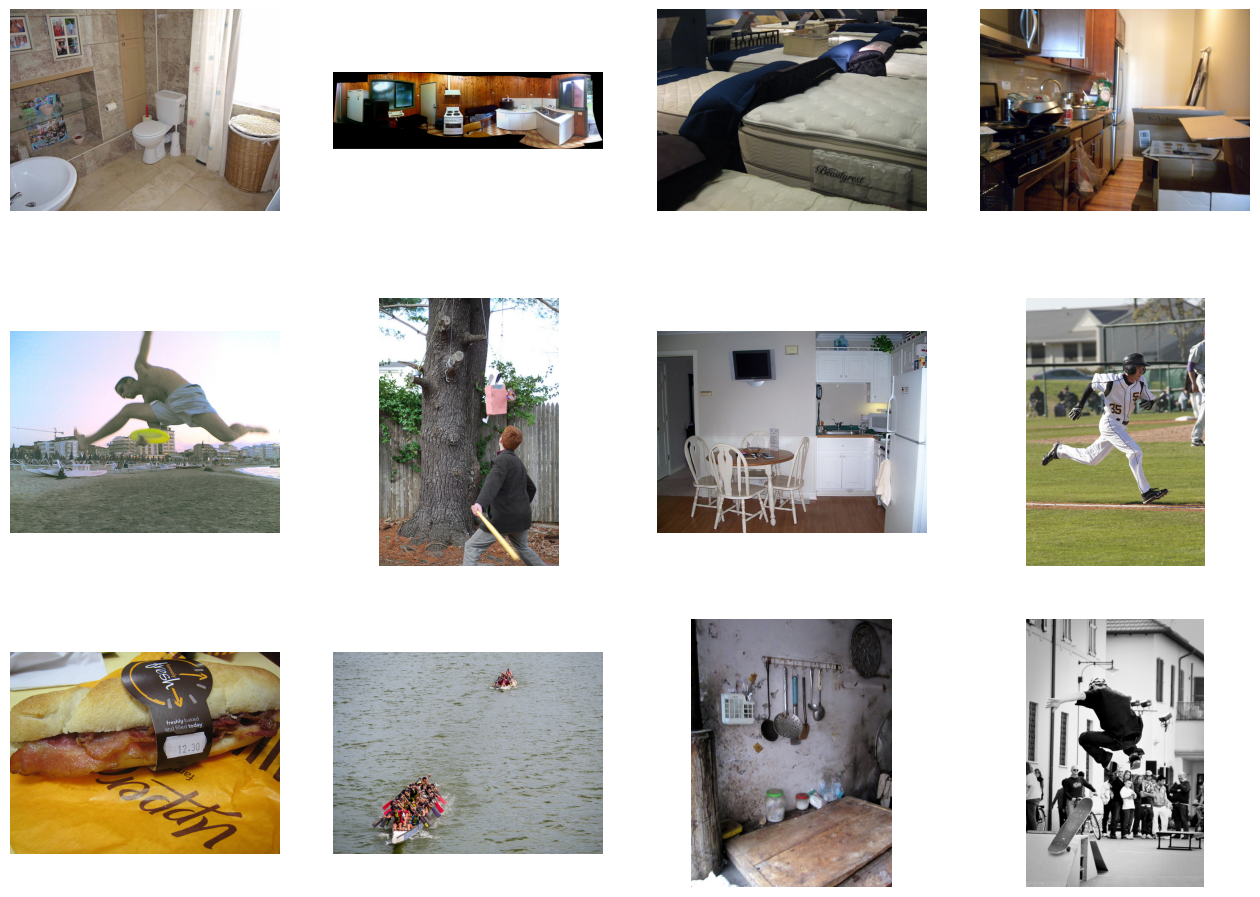

In [17]:
import matplotlib.pyplot as plt
import skimage.io as io

# 랜덤 파일 읽기, imgidss 확인!! -전체코코인지 일부인지
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    I = io.imread(img_path)
    plt.imshow(I)
    print( updated_dict[img_path][0])

plt.show()

In [19]:
import pickle
import tensorflow as tf
from tensorflow.io.gfile import GFile
from tensorflow.keras.preprocessing.text import Tokenizer

In [20]:
  with open("/content/drive/MyDrive/3조/test2_pickle", "rb") as f:    
    df = pickle.load(f)

In [21]:
print(df.columns)


# updated_dict = dataframe.set_index("Img_address").iloc[:,2:-1].to_dict()
updated_dict={}

for i in range(len(df)):
  img_address = df.iloc[i]['Img_address']
  caption_list = [df.iloc[i]['caption_1'],df.iloc[i]['caption_2'],df.iloc[i]['caption_3'],df.iloc[i]['caption_4'],df.iloc[i]['caption_5']]

  updated_dict[img_address] =caption_list

Index(['id_key', 'Img_address', 'caption_1', 'caption_2', 'caption_3',
       'caption_4', 'caption_5', 'caption_list'],
      dtype='object')


In [22]:
dataset =updated_dict

print(len(dataset))
print(list(dataset.items())[0])
# list(image_features.keys())[0]

# dataset 에 <start>, <end> 넣기, LSTM 용


newdataset = {k: ['<start> '   +cap+ ' <end>' for cap in caps] for k,caps in dataset.items()}

print(len(newdataset))
print(list(newdataset.items())[0])
print(len(list(newdataset.values())[0]))

dataset =newdataset


28846
('/content/content/custom_train_coco_30k/000000000025.jpg', ['A giraffe eating food from the top of the tree.', 'A giraffe standing up nearby a tree ', 'A giraffe mother with its baby in the forest.', 'Two giraffes standing in a tree filled area.', 'A giraffe standing next to a forest filled with trees.'])
28846
('/content/content/custom_train_coco_30k/000000000025.jpg', ['<start> A giraffe eating food from the top of the tree. <end>', '<start> A giraffe standing up nearby a tree  <end>', '<start> A giraffe mother with its baby in the forest. <end>', '<start> Two giraffes standing in a tree filled area. <end>', '<start> A giraffe standing next to a forest filled with trees. <end>'])
5


Preprocess and tokenize the captions

In [23]:
import itertools

# from sklearn.model_selection import train_test_split



keys = list(dataset.keys())

random.seed(7)
random.shuffle(keys)
# 임시 : sample은 개수
train_size= int(len(dataset)*0.9)

val_size = len(dataset)-train_size
print(train_size, val_size)


train_keys =keys [:train_size]
val_keys = keys[train_size:]

data_train = {k : dataset[k] for k in train_keys}
data_val = {k : dataset[k] for k in val_keys}



25961 2885


In [24]:
list(data_train.items())[:2]

[('/content/content/custom_train_coco_30k/000000230903.jpg',
  ['<start> A yellow and red train traveling down tracks. <end>',
   '<start> A silver, red, and yellow train approaching on the tracks.  <end>',
   '<start> A yellow and red train is at a train stop.  <end>',
   '<start> Front diagonal view of commuter train on tracks, outside between platforms. <end>',
   '<start> A train sits stationary on a track adjacent to a house.  <end>']),
 ('/content/content/custom_train_coco_30k/000000535100.jpg',
  ['<start> A lady sits by an airport window as an aircraft is closely parked. <end>',
   '<start> The woman smiles while sitting in an airport. <end>',
   '<start> a woman stands in front of a window <end>',
   '<start> a photo of a person sitting near a window with an air plane outside <end>',
   '<start> A woman sitting next to a window smiles for a picture. <end>'])]

Preprocess and tokenize the captions

In [28]:
from itertools import chain
from tensorflow.keras.preprocessing.text import Tokenizer

# 30K 단어 토큰화 # 15k만들기는 아직 보류

def tokenize_mycaption(dataset, max_words=15000):
  
  flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

  tokenizer = Tokenizer( oov_token='<oov>',num_words =max_words) # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  total_vocab_words = len(tokenizer.word_index) 
  print("Vocabulary length: ", total_vocab_words)
  print(list(tokenizer.word_index.keys())[:10])
  return tokenizer, total_vocab_words

tokenizer, total_vocab_words = tokenize_mycaption(newdataset, max_words=9000)


Vocabulary length:  15215
['<oov>', 'a', 'end', 'start', 'on', 'of', 'the', 'in', 'with', 'and']


In [29]:
total_words = 9000

In [26]:
# max_index = 0
# for seq in tokenizer.texts_to_sequences(dataset):
#   max_index =max(max_index, max(seq))
# total_words = max_index+1
# print(total_words)

14827


In [34]:
# # 해당 3만개 데이터에 대한 tokenizer 저장  (15691 단어 수)

# import pickle

# # Save the configuration and weights to a file
# with open(f"my_tokenizer_{my_part}.pkl", "wb") as f:
#     pickle.dump({"tokenizer": tokenizer}, f)

In [35]:
dataset_list = list(dataset)


sample_link = dataset_list[0]


sample_captions = dataset[sample_link]


sample_link, sample_captions

('/content/content/custom_train_coco_30k/000000000025.jpg',
 ['<start> A giraffe eating food from the top of the tree. <end>',
  '<start> A giraffe standing up nearby a tree  <end>',
  '<start> A giraffe mother with its baby in the forest. <end>',
  '<start> Two giraffes standing in a tree filled area. <end>',
  '<start> A giraffe standing next to a forest filled with trees. <end>'])

In [30]:
# Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
    # featurewise_center=False,
    # samplewise_center=False,
    # featurewise_std_normalization=False,
    # samplewise_std_normalization=False,
    # zca_whitening=False,
    # zca_epsilon=1e-06,
    # rotation_range=0,
    width_shift_range=0.1, # changed
    height_shift_range=0.1, # changed
    # brightness_range=None,
    shear_range=0.1, # changed
    zoom_range=0.1, # changed
    # channel_shift_range=0.0,
    # fill_mode='nearest',
    # cval=0.0,
    horizontal_flip=True, # changed
    vertical_flip=False,
    # rescale=None,
    # preprocessing_function=None,
    # data_format=None,
    # validation_split=0.0,
    # interpolation_order=1,
    # dtype=None
)

In [31]:
# Encoder 인 Xception 모델 호출, image_feature, imsize, error_imgs 선언, img_preprocess (이미지 사이즈 model 에 맞게 + resize, + 정규화 + feature 추출)


from tensorflow.keras.applications.xception import Xception
from tqdm.notebook import tqdm
import cv2
import numpy as np

model = Xception(include_top=False, pooling='avg',  weights='imagenet')

# model.compile()

image_features = {}

imsize = (299,299)
# dataset.keys()
error_imgs = []
# 윤성(230411/aug : True->False)
def img_preprocess(dataset=dataset,imsize=imsize, model=model, aug =True  ):
# def img_preprocess(dataset=dataset,imsize=imsize, model=model, aug =False  ):
    for img in tqdm(list(dataset.keys())):
        try:
            image = io.imread(img)
            if image.ndim != 3:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # Resize each image size 299 x 299 or 224 X 224
            image = cv2.resize(image, (imsize[1], imsize[0]))
            image = np.expand_dims(image, axis=0)
            if aug == True:
              augmented_image = data_gen.flow(image, batch_size=1).next()
              image = augmented_image

            # Normalize image pixels
            image = image / 127.5
            image = image - 1.0

            # Extract features from image
            feature = model.predict(image)
            
            [img] = feature

        except:
            print(f"Failed to process image {img}")
            error_imgs.append[img]

In [32]:
# 윤성(230411 주석처리)
# MobileNet Feature extraction 용
from tensorflow.keras.layers import GlobalAveragePooling2D

IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

x = mobilenet.output
x = GlobalAveragePooling2D()(x)

modified_mobilenetv3small = Model(inputs=mobilenet.input, outputs=x)

# img_preprocess(dataset, imsize =IMAGE_SHAPE, model = modified_mobilenetv3small)


In [33]:
# 윤성추가(230411)
# model_incep.summary()
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

In [34]:
# from tensorflow.keras.layers import GlobalAveragePooling2D

IMAGE_SHAPE=(224, 224, 3)

vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
) 
vgg16.trainable=False

x = vgg16.output
x = GlobalAveragePooling2D()(x)

modified_vgg16 = Model(inputs=vgg16.input, outputs=x)

In [35]:
#윤성추가(230411)
# modified_vgg16.summary()

# img_preprocess(dataset, imsize =IMAGE_SHAPE, model = modified_vgg16)
# 뒤에 각모델마다  호출할때 모델 피팅 따로적용해야함

In [36]:
# 윤성 07,08,09
import pickle
# Get the tokenizer's configuration and weights
# image_features

# 각자 Sampletrain 별로 저장하기 
# ex) train

# 윤성(230411/aug : True->False)
# with open(f"my_feature_{len(image_features)}_{my_part}.pkl", "wb") as f:
# with open(f"vgg16_feature_{len(image_features)}_aug_True.pkl", "wb") as f:
# with open(f"vgg16_feature_{len(image_features)}_aug_False.pkl", "wb") as f:
# with open("vgg16_feature_30000_aug_True.pkl", "wb") as f:  
#     pickle.dump({"feature": image_features}, f)

In [37]:
import pickle

extract =False 

# model_e = 'vgg_t' # false for aug
# model_e = 'xception_t' # false for aug
model_e = 'xception_f' # f for aug

# model_e = 'mobilenet_t' # false for aug

if extract == True:
  pass
# img_preprocess(dataset)
else:
  # feature 파일 로드, (dict 형태)

  # with open("/content/drive/MyDrive/3조/vgg pkl/vgg16_feature_10000_01.pkl", "rb") as f:  
# 윤성(230411 경로수정)


  if model_e=='vgg16_t':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_VGG16_30K/vgg16_feature_30000_aug_True.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)
  elif model_e=='xception_t':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_Xception_30K/my_feature_30000_yes_aug.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)
  elif model_e=='xception_f':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_Xception_30K/my_feature_30000_no_aug.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)

  elif model_e=='mobilenet_t':
      print("loading :",model_e)
      with open("/content/drive/MyDrive/3조/features_Mobilenet_30K/my_feature_30000_mb_yes_aug.pkl", "rb") as f:    
        load_feature_file = pickle.load(f)
      
  

  load_features = list(load_feature_file.values())[0]
  print(len(load_features))

  # print(type(load_features))
  keys = list(load_features.keys())
  values =list(load_features.values())


  load_feature_dict  = {}
  print(load_feature_dict)
  my_filepath_key =[sample_path+"/"+ key[-16:] for key in keys]
  print("my_filepath_key:", my_filepath_key[0])
  for i in range(len(keys)):
      load_feature_dict[my_filepath_key[i]] = values[i]


  print("load_feature_dict:",len(load_feature_dict))

  first_item_key = list(load_feature_dict.keys())[0]
  first_item_value = list(load_feature_dict.values())[0]


  # io.imread(first_item_key)


  # 다시 키를 내경로에 맞게 수정하는 과정 필요



  print(first_item_value.shape)
  print( keys[0])

loading : xception_f
30000
{}
my_filepath_key: /content/content/custom_train_coco_30k/000000000025.jpg
load_feature_dict: 30000
(1, 2048)
/content/content/custom_train_coco_30k/000000000025.jpg


In [38]:
len(load_feature_dict)

30000

In [39]:
# testsample_dict

# img_preprocess ( dataset = testsample_dict )


000000000025.jpg
['/content/content/custom_train_coco_30k/000000000025.jpg', '/content/content/custom_train_coco_30k/000000000081.jpg', '/content/content/custom_train_coco_30k/000000000089.jpg', '/content/content/custom_train_coco_30k/000000000092.jpg', '/content/content/custom_train_coco_30k/000000000151.jpg']
55


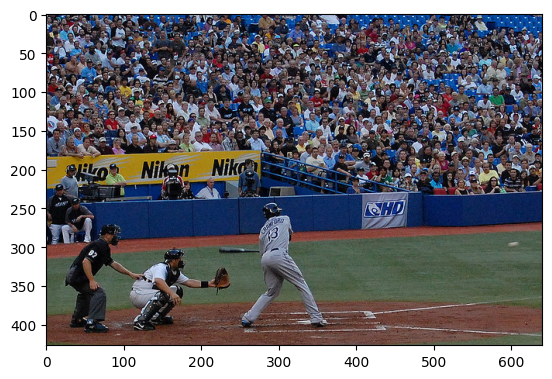

'/content/content/custom_train_coco_30k/000000000025.jpg'

In [40]:
# 이미지 읽어보기 [0]

print(first_item_key[-16:])

print(my_filepath_key[:5])
print(len(my_filepath_key[0]))

# index [0:9999]
im = io.imread(my_filepath_key[23])

plt.imshow(im)
plt.show()
'/content/content/custom_train_coco_30k/000000000544.jpg'
'/content/content/custom_train_coco_30k/000000000025.jpg'

In [41]:
dataset[my_filepath_key[12]]

['<start> Two people standing in a kitchen looking around.  <end>',
 '<start> A couple of men are standing in a kitchen <end>',
 '<start> Two people looking at a large kitchen  <end>',
 '<start> An elderly man and woman looking around in a kitchen. <end>',
 '<start> Two people standing close to each other while standing in a kitchen. <end>']

In [50]:
if load_feature_dict:
  image_features = load_feature_dict


print("Image features length: ", len(image_features))

Image features length:  30000


In [51]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length_f(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length_f(dataset)
print(max_length)
max_length_v = max_length_f(data_val)
print(max_length_v)

max_length_t = max_length_f(data_train)
print(max_length_t)


max_length

26
25
26


26

Make a Data Generator
We have to train our model on 6221 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6221 images is not possible to hold into memory so we will be using a generator method that will yield batches.

The generator will yield the input and output sequence.

For example:¶
The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

Capture.PNG

In [52]:
#create input-output sequence pairs from the image description.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
        #  description 인 경우 10,000개 
            feature = features[key][0]
            # print("features",type(features), len(features), list(features.keys())[0]) #  features 자체는 image_features dict
            # print("feature",type(feature), len(feature))
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    num=0
    # walk through each description for the image
    for desc in desc_list: # desc_list 는 caption의 list를 뜻함
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # print(len(seq))
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # print("in_seq",in_seq)
            
            # encode output sequence
            # out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            out_seq = to_categorical([out_seq], num_classes=total_words+1)[0] # start, end token 추가 +1

            # print("out_seq",out_seq, "\n", len(out_seq))
            
            # store
            # append num
            num+=1
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
    # print("append 한 횟수 :",num)

    return np.array(X1), np.array(X2), np.array(y)

In [57]:
# create_sequences(tokenizer, max_length, data_train, image_features)

gen = data_generator(data_val, image_features, tokenizer, max_length)

# for i, a in enumerate(gen):
#   print(i)
#   if i >2:
#    break;


print(list(image_features.items())[0])
print(list(data_train.items())[0])




('/content/content/custom_train_coco_30k/000000000025.jpg', array([[0.08284476, 0.        , 0.05672558, ..., 0.10530851, 0.        ,
        0.42527425]], dtype=float32))
('/content/content/custom_train_coco_30k/000000230903.jpg', ['<start> A yellow and red train traveling down tracks. <end>', '<start> A silver, red, and yellow train approaching on the tracks.  <end>', '<start> A yellow and red train is at a train stop.  <end>', '<start> Front diagonal view of commuter train on tracks, outside between platforms. <end>', '<start> A train sits stationary on a track adjacent to a house.  <end>'])


In [58]:
model_e[:-2]

'xception'

In [59]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention

# define the captioning model
def define_model(total_words, max_length, model= model_e[:-2]):
    # features from the CNN model squeezed from 2048 to 256 nodes

    if model == "xception":
        inputs1 = Input(shape=(2048,)) #for Xception (1,2048)
    elif model == "vgg16":
        inputs1 = Input(shape=(512,))# for VGG 512
    elif model == "mobilenetv3small":
        inputs1 = Input(shape=(576,)) #for Xception (1,2048)


    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam') # metrics = ['acc']

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [60]:
# train our model
import os

try:
  os.mkdir("models")
except:
  print("models folder already exists")

# testsample_dict
print(max_length)
caption_model = define_model(total_words+1, max_length)

26
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 256)      2304256     ['input_5[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_4[0][0]']                
                                                                                         

In [61]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'loss', patience =3, verbose = 1)

In [63]:
from datetime import datetime
current_time = datetime.now()
timestamp = int(current_time.timestamp())
# print(timestamp)

fit_num=0




# model_save_name  =f"/content/drive/MyDrive/3조/Models/vgg16_{timestamp}+FN+{str(fit_num)}_caption_model.h5"
model_save_name  =f"/content/drive/MyDrive/3조/Models/{model_e}_{timestamp}+FN+{str(fit_num)}_caption_model.h5"

# print(model_save_name)
# caption_model.save("test_model.h5")
# caption_model.save(model_save_name)



BATCH_SIZE = 32


def train_our_model(data_train= data_train,
                    data_val=data_val,batch =BATCH_SIZE,
                    model =caption_model):
  global fit_num

  index = model_save_name.find("FN") + 3
  fit_num = int(model_save_name[index])  

  fit_num+=1

  steps_per_epoch_train = train_size //BATCH_SIZE
  steps_per_epoch_val = val_size // BATCH_SIZE

  print('Dataset: ', len(dataset))
  print('Descriptions: val=', len(data_val))
  print('Descriptions: train=', len(data_train))
  print('Photos: =', len(image_features))
  print('Token Vocabulary Size:', total_words)
  print('Total vocabulary:', total_vocab_words)

  print('Description Length: ', max_length)

  
  fit_set = 1
  EPOCHS=1
  # steps = len(dataset)

  # making a directory models to save our models

  # yield  []
  for i in range(fit_set):

    # train, val generator 
      train_generator = data_generator(data_train, image_features,tokenizer, max_length_t)
      val_generator = data_generator(data_val, image_features, tokenizer, max_length_v)
      # fit with generators with callbacks
      test_fit =model.fit(train_generator,  steps_per_epoch= steps_per_epoch_train,
                          validation_data =val_generator, validation_steps= steps_per_epoch_val,
                          callbacks=[early_stopping],epochs=EPOCHS,)
    # model.fit(generator, epochs=5, steps_per_epoch= steps, verbose=1, batch_size=BATCH_SIZE, validation_set = validation_loss = )      

      # 윤성(230412 비활성화)
      # model.save("models/model_" + str(i) +str(fit_num)+ ".h5")   
      model.save(model_save_name)
  return test_fit


In [64]:
# print(model_save_name)
# caption_model.save(model_save_name)

fit 실행(epochs)

In [65]:
history = train_our_model(model = caption_model)

Dataset:  28846
Descriptions: val= 2885
Descriptions: train= 25961
Photos: = 30000
Token Vocabulary Size: 9000
Total vocabulary: 15215
Description Length:  26
811/811 [==============================] - 87s 94ms/step - loss: 5.1072 - val_loss: 4.5714


dict_keys(['loss', 'val_loss'])


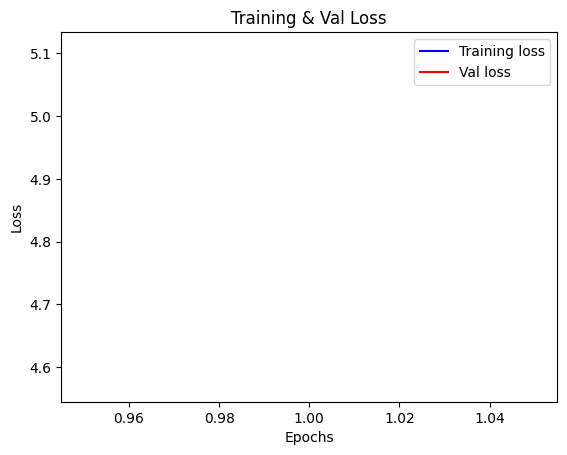

In [66]:
import matplotlib.pyplot as plt

# Get the training loss history
# train_loss = caption_model.history['loss']
# print(caption_model.history.history.keys())
print(history.history.keys())

train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Val loss')
plt.title('Training & Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [67]:
# loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/model_01_vgg16.h5")
# 윤성(230411)
# loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/model_01_vgg16_30k_aug(false).h5")
# 윤성 파일명 변경

# loaded_model = tf.keras.saving.load_model("models/model_01.h5")
for i,model_path in enumerate (os.listdir("/content/drive/MyDrive/3조/Models/")) :
  # print(i,model_path)  
  # if f"FN+{str (i)}" in model_path :
  if f"FN" in model_path and "mobilenet" in model_path:  
    print(model_path)
    loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/"+model_path)
# print(loaded_model)
loaded_model.summary()

mobilenet_t_1681366497+FN+0_caption_model.h5
mobilenet_t_1681371160+FN+0_caption_model.h5
Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 576)]        0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 26, 256)      3895296     ['input_55[0][0]']               
                                                                                                  
 dropout_44 (Dropout)           (None, 576)          0           ['input_54[0][0]']               
 

In [68]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [69]:
# train_our_model(dataset,model=loaded_model)

In [70]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    # im=Image.open(filename)
    # print(filename)
    # print(im)
    img_paths.append(filename)

    if len(img_paths)>10:
      break
print(img_paths)

['./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000571635.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000202658.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000203564.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000410627.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000208408.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000581177.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000153184.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000027842.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_tr

In [71]:
print(model_e[:-2])

xception


In [72]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")

        if model_e[:-2] == "mobilenet":
            image = image.resize((224,224))
            print("resizing")
        else:
            image = image.resize((299,299))


        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end' or word =='<end>':
            in_text = in_text[:-3]  +"<"+in_text [-3:] + ">"
            break
    return in_text

In [73]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# 윤성 (230412 앞에 있다)

# IMAGE_SHAPE=(224, 224, 3)

# vgg16 = tf.keras.applications.vgg16.VGG16(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation='softmax'
# ) 
# vgg16.trainable=False

# x = vgg16.output
# x = GlobalAveragePooling2D()(x)

# modified_vgg16 = Model(inputs=vgg16.input, outputs=x)

In [74]:


# CNN_model= modified_mobilenetv3small
# caption_model.summary()
# CNN_model.summary()

CNN_model= model

1/1 [==============================] - 5s 5s/step



<start> a man of a street with a street <end>


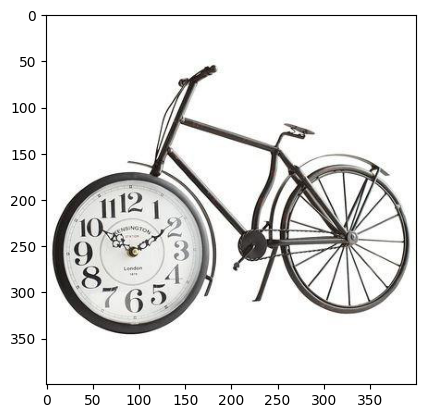

In [75]:


ii = 2

photo = extract_features(img_paths[ii], CNN_model)
img = Image.open(img_paths[ii])
description = generate_desc(caption_model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [77]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    # im=Image.open(filename)
    # print(filename)
    # print(im)
    img_paths.append(filename)

    if len(img_paths)>10:
      break



print(img_paths)

['./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000571635.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000202658.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000203564.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000410627.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000208408.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000581177.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000153184.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000027842.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_tr

In [78]:
len(img_paths)

11

In [79]:
img_paths


['./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000571635.jpg',
 './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000202658.jpg',
 './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000203564.jpg',
 './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000410627.jpg',
 './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000208408.jpg',
 './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000581177.jpg',
 './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000153184.jpg',
 './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000027842.jpg',
 './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_trai

1/1 [==============================] - 0s 22ms/step


predict:    <start> a man of a man on a table <end>
answer:    <start> A group of men and women standing in formal wear in a den. <end>
1/1 [==============================] - 0s 22ms/step


predict:    <start> a man riding a wave on a <end>
answer:    <start> the man is on his surfboard riding a big wave <end>
1/1 [==============================] - 0s 21ms/step


predict:    <start> a man of a white and in a <end>
answer:    <start> Five airplanes flying in the clouds and sky.  <end>
1/1 [==============================] - 0s 22ms/step


predict:    <start> a man of a table on a table <end>
answer:    <start> A big pretty white swan swimming in a river. <end>
1/1 [==============================] - 0s 21ms/step


predict:    <start> a woman with a table with a table <end>
answer:    <start> An orange and white cat sitting on top of a TV. <end>
1/1 [==============================] - 0s 22ms/step


predict:    <start> a street and a str

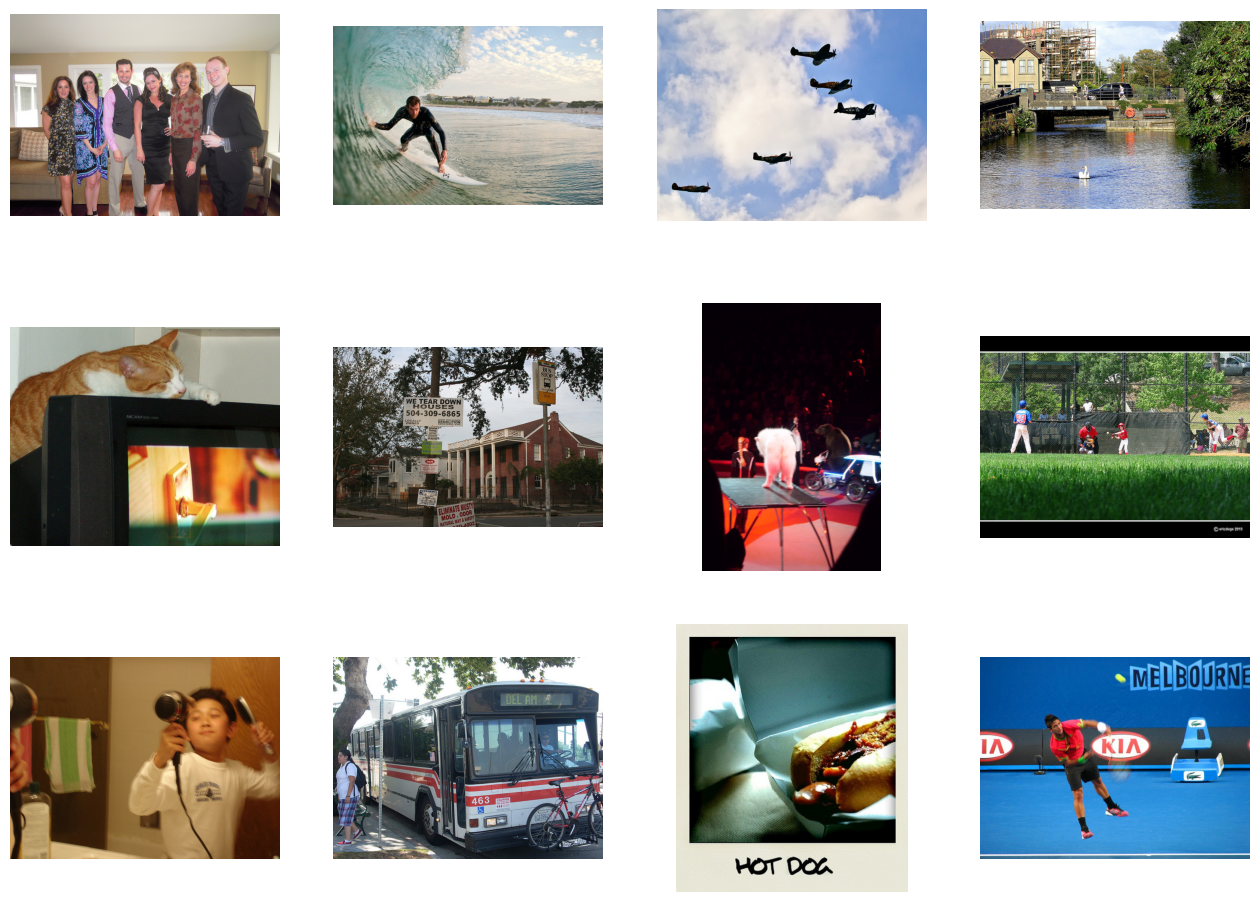

In [80]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = list(dataset.keys())
random.shuffle(next_pix)

# xception_model = Xception(include_top=False, pooling="avg")
# for i, image in enumerate(img_paths):
for i, image in enumerate(next_pix[0:12]):
  
  photo = extract_features(image,CNN_model)
  img = Image.open(image)
  description = generate_desc(caption_model, tokenizer, photo, max_length)
  print("\n")
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')
  plt.imshow(img)

  print("predict:   ", description)
  print("answer:   ",dataset[image][0])

plt.show()

In [ ]:
tokenizer.word_index.get('end')
# tokenizer.word_index.get('start')
# tokenizer.word_index.get('toilet')


# tokenizer.word_index.get('<end>')


In [ ]:

# token_input = input()
# token_check= token_input
# print(token_check)

token_i=tokenizer.word_index.get("soccer")

print("input_index:", token_i)

In [ ]:
  print(list(tokenizer.word_index.keys())[:200])


Image size:  (640, 428, 3)
hog_image
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.125      0.60355338 ... 0.1875     0.57766503 0.        ]
 [0.         0.60355338 0.125      ... 0.57766503 0.1875     0.        ]
 ...
 [0.         5.85107642 0.1875     ... 0.75       0.88672507 0.        ]
 [0.         0.1875     5.85107642 ... 0.88672507 0.75       0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


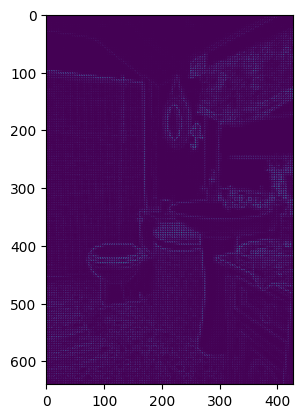

In [81]:
from skimage.feature import hog

def hog_images(crop):    
    image=crop[:,:,1]    
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(2, 2), visualize=True)    
    return hog_image

# img_paths = ["../input/cocods/val2017/val2017/000000035682.jpg"]
img_paths
im = cv2.imread(img_paths[0])
print ("Image size: ", im.shape)
hog_image = hog_images(im)
plt.imshow(hog_image)

print ('hog_image\n',hog_image)

normalized hog_matrix
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.16718974 0.19119113 ... 0.06901669 0.19830598 0.        ]
 [0.         0.19119113 0.16718974 ... 0.19830598 0.06901669 0.        ]
 ...
 [0.         0.29708177 0.24293684 ... 0.16850035 0.18985671 0.        ]
 [0.         0.24293684 0.29708177 ... 0.18985671 0.16850035 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
hog_vec
 [0. 0. 0. ... 0. 0. 0.]


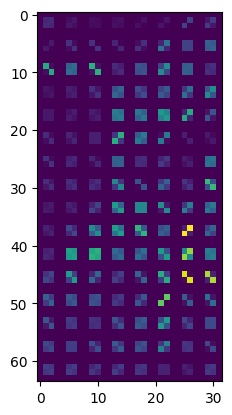

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

im = cv2.resize (im, (32,64))
hog_image = hog_images(im)
plt.imshow(hog_image)

hog_image = np.array(hog_image)
scaler.fit(hog_image)
scaler.transform(hog_image)
print ('normalized hog_matrix\n',scaler.transform(hog_image))
hog_vec = hog_image.flatten()

print ('hog_vec\n',hog_vec)

In [86]:
our_CNN_feature = extract_features(img_paths[0], CNN_model)
scaler.fit(our_CNN_feature)
scaler.transform(our_CNN_feature)
print ('SSD_feature',our_CNN_feature)

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(our_CNN_feature, hog_vec)/(norm(our_CNN_feature)*norm(hog_vec))
print ("cos_sim",cos_sim)

1/1 [==============================] - 0s 27ms/step
SSD_feature [[0.45189446 0.14297663 0.03214789 ... 0.0872236  0.18692678 0.10297367]]
cos_sim [0.23202137]


original size (480, 640, 3)


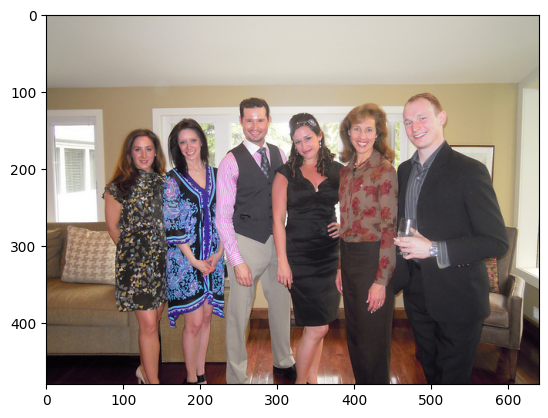

In [88]:
im2_path = next_pix[0]

im2 = cv2.imread(im2_path)
print ('original size',im2.shape)
img2 = Image.open(im2_path)
plt.imshow(img2)

1/1 [==============================] - 0s 50ms/step
cos_sim2 [0.23167344]


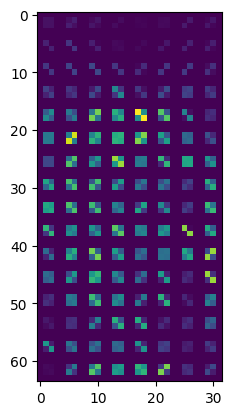

In [91]:
im2 =  cv2.resize(im2,(32,64))
hog_image2 = hog_images(im2)
plt.imshow(hog_image2)

hog_image2 = np.array(hog_image2)
scaler.fit(hog_image2)
scaler.transform(hog_image2)
hog_vec2 = hog_image2.flatten()


our_CNN_feature = extract_features(im2_path, CNN_model)
scaler.fit(our_CNN_feature)
scaler.transform(our_CNN_feature)

cos_sim2 = dot(our_CNN_feature, hog_vec2)/(norm(our_CNN_feature)*norm(hog_vec2))
print ("cos_sim2",cos_sim2)

Image size:  (480, 640, 3)
hog_image
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.62903094 1.10379696 ... 0.61427669 0.9045085  0.        ]
 [0.         1.10379696 0.62903094 ... 0.9045085  0.61427669 0.        ]
 ...
 [0.         0.625      0.96642753 ... 6.26639783 1.49055362 0.        ]
 [0.         0.96642753 0.625      ... 1.49055362 6.26639783 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


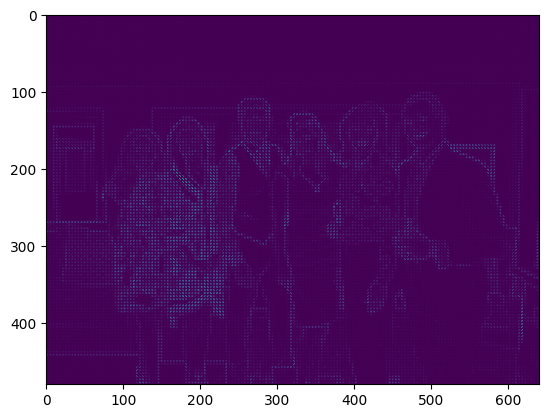

In [92]:
# img_paths # 
im = cv2.imread(next_pix[0])
print ("Image size: ", im.shape)
hog_image = hog_images(im)
plt.imshow(hog_image)

print ('hog_image\n',hog_image)

normalized hog_matrix
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0700544  0.06800035 ... 0.01888466 0.07034298 0.        ]
 [0.         0.06800035 0.0700544  ... 0.07034298 0.01888466 0.        ]
 ...
 [0.         0.03885229 0.02601298 ... 0.09025771 0.25727592 0.        ]
 [0.         0.02601298 0.03885229 ... 0.25727592 0.09025771 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
hog_vec
 [0. 0. 0. ... 0. 0. 0.]


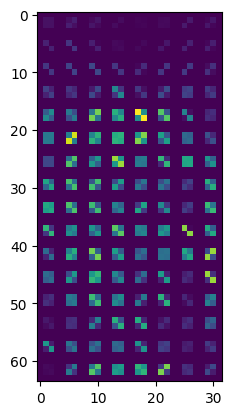

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

im = cv2.resize (im, (32,64))
hog_image = hog_images(im)
plt.imshow(hog_image)

hog_image = np.array(hog_image)
scaler.fit(hog_image)
scaler.transform(hog_image)
print ('normalized hog_matrix\n',scaler.transform(hog_image))
hog_vec = hog_image.flatten()

print ('hog_vec\n',hog_vec)